In [38]:
import gym
from gym import spaces
import random
from stable_baselines3 import PPO
import numpy as np
from threading import Thread
import threading

In [39]:
# for thread in threading.enumerate(): 
#     print(thread.name)

In [40]:
# for thread in threading.enumerate(): 
#     print(thread.name)

### Agent-based RL in Simple Worlds

In [41]:
env = gym.make("CartPole-v1")
# env = gym.make('MountainCar-v0')

In [42]:
import import_ipynb
from aiagentbase import AIAgent,Controller,Memory,Perception,Actor

In [43]:
class CartWorld():
    def __init__(self,env):
        self.env=env
        self.test_episodes=[]
        self.world_over=False
    def stop(self):
        self.world_over=True
    def run(self,agent=None,n_episodes=10,episode_maxlen=10):
        agent.observation_space=env.observation_space
        if 'training' not in agent.__dict__: agent.training=False
        if agent.training: testing=False 
        else: testing=True
        if agent.training: print('Starting Training time: ',agent.time)
        for episode in range(n_episodes):
            # print('CartAgent','starting episode')
            state=self.env.reset()
            agent.begin()
            # print(agent.time)#,agent.ep)
            for t in range(episode_maxlen):
                # env.render(mode='rgb_array')
                action=agent.act(state)
                # print(episode,t,'Action: ', action)
                state, reward, done, info = env.step(action)
                agent.reward((reward,done,info))
                # print(episode,t,'Reward sent: ', reward)
                if done:
                    break
            if self.world_over:break
            if not agent.training: self.test_episodes+=[episode]
            if not agent.training and not testing: 
                print('Training Over at time: ',agent.time)
                testing=True
        print('Testing Done time: ', agent.time, ' Reward: ', agent.avg_rew())
        return agent.avg_rew()

In [44]:
#Doesnt use AIAgent Architecture Classes but implements the same interface - for initial testing
class RandomAgent():
    def __init__(self,action_space):
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
    def act(self,state):
        action = self.action_space.sample()
        return action
    def reward(self,rew):
        self.tot_rew+=rew[0]
    def begin(self,state):
        self.rewL+=[self.tot_rew]
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [45]:
class RandomAIAgent(AIAgent):
    def __init__(self,action_space):
        super().__init__()
        self.actor=self.Actor(parent=self)
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
        
    class Actor(Actor):
        def __init__(self,parent): 
            super().__init__(parent=parent)
        def call_model(self,state):
        ##Overriding AIAgent.Model
            action = self.parent.action_space.sample()
            return action
    
    def reward(self,rew):
        ##Augmenting AIAgent
        self.tot_rew+=rew[0]
        return super().reward(rew)
    def begin(self):
        ##Augmenting AIAgent
        self.rewL+=[self.tot_rew]
        super().begin()
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [46]:
agent=RandomAIAgent(env.action_space)
agent.training=False

In [47]:
agent.debug=False
agent.use_memory=True

In [48]:
world=CartWorld(env=env)

In [49]:
worldthread=Thread(name='world',target=world.run,args=(agent,1000,200))

In [50]:
worldthread.start()

Testing Done time:  22503  Reward:  11053.881


In [51]:
# world.run(agent,10,10)

### Training an AI Agent's Model using an off-the shelf RL procedure
Create a local environment called by a Monitor thread running within Agent, which implements or
re-uses an on-policy RL training procedure (such as PPO etc.). The env has an input and output queue. If a training flag is set, the Agent uses a ProxyModel place of its normal model to compute actions: The actor-state is placed in the env's input queue and an action is awaited from the env's output queue.

The monitor starts by calling the env.reset method that waits on the input queue to receive 
and then return a state. The monitor thread computes an action on the current state and calls
env.step(action), which places the action in the output queue and awaits a reward from the input
queue. After receiving a reward, step again waits for the next state on the input queue.
Once this is also received, both next stte and reward are returned.

In [52]:
from queue import Queue
from threading import Thread
import threading
import sys

In [53]:
class RLAgent(AIAgent):
    def __init__(self,action_space,observation_space,training_steps=20000):
        ##Augmenting AIAgent
        super().__init__()
        ##Local RL environment running in a thread to interact with World via queues
        self.env=self.TrainingEnv(parent=self)
        self.env.action_space=action_space
        self.env.observation_space=observation_space
        self.monitor=self.Monitor(parent=self)
        self.set_training(True)
        self.monitorthread=Thread(name='monitor',target=self.monitor.train,args=(training_steps,))
        self.tot_rew=0
        self.logL=[]
        self.kill=False
        ##Override Actor
        self.model=PPO('MlpPolicy', self.env, verbose=0)
        self.actor=self.Actor(parent=self,model=self.model)
        
    def start(self):
        self.monitorthread.start() 
    
    def stop(self):
        self.kill=True
    
    def log(self,entry):
        self.logL+=[entry]
        
    def set_training(self,value):
        self.training=value
        
    class TrainingEnv(gym.Env):
        def __init__(self,parent):
            self.parent=parent
            # self.observation_space=spaces.Box(
            #     low=np.array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38]), 
            #     high=np.array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38]), 
            #     shape=(4,), dtype=np.float32)
            self.inputS=Queue() #written by act read by reset and step
            self.outputS=Queue() #written by act read by act
            self.rewardI=Queue() #written by act and read by step
            self.actionO=Queue() #written by step and read by act
            self.counter=0
        def reset(self):
            # print('reset')
            self.parent.log(('reset waiting',self.counter))
            self.state=self.inputS.get()
            return self.state
        def step(self,action):
            if self.parent.kill: sys.exit(-1)
            # print('step')
            self.actionO.put(action)
            self.parent.log(('step put action',self.counter))
            self.parent.log((self.counter,action))
            self.parent.log(('step waiting for reward',self.counter))
            reward,done,info=self.rewardI.get()
            if not done:
                self.parent.log(('step waiting for next state',self.counter))
                next_state=self.inputS.get()
                self.counter+=1
                self.parent.log((self.counter,next_state))
            else: next_state=self.state
            # print(self.counter,done)
            return next_state,reward,done,info
        def print_queues(self):
            print('inputS',self.inputS.queue)
            print('actionO',self.actionO.queue)
            print('rewardI',self.rewardI.queue)
            print('outputS',self.outputS.queue)
             
    class Monitor():
        def __init__(self,parent):
            self.parent=parent
        def run(self,training_steps,N_EPISODES=10):
            for episode in range(N_EPISODES):
                state=self.parent.env.reset()
                for steps in range(training_steps):
                    # env.render()
                    action=self.parent.env.action_space.sample()
                    state, reward, done, info = self.parent.env.step(action)
                    # print(next_state, reward, done, info, action)
            self.parent.set_training(False)
        def train(self,training_steps):
            self.parent.actor.model.learn(total_timesteps=training_steps)
            self.parent.env.actionO.put(self.parent.env.action_space.sample())
            self.parent.set_training(False)
            # self.parent.log((self.parent.training,self.parent))
    
    class Actor(Actor):
        def __init__(self,parent,model):
            super().__init__(parent=parent,model=model)
        def call_model(self,state):
        ##Overriding AIAgent
            time=self.parent.time
            if self.parent.training: 
                self.parent.env.inputS.put(state)
                self.parent.log(('call model put state at time',time))
                self.parent.log(('call model waiting for action at time',time))
                try: action = self.parent.env.actionO.get()#timeout=5)
                except: action=0
                self.parent.log(('call model received action at time',time))
            else: action, _states = self.model.predict(state)
            return action
    
    def reward(self,reward):
        ##Augmenting AIAgent
        reward=super().reward(reward)
        self.tot_rew+=reward[0]
        if self.training: 
            self.env.rewardI.put(reward)
            self.log(('call model put reward at time',self.time))
    def begin(self):
        ##Augmenting AIAgent
        self.rewL+=[self.tot_rew]
        super().begin()
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [54]:
agent=RLAgent(action_space=env.action_space,observation_space=env.observation_space,training_steps=20000)

In [55]:
agent.debug=False
agent.use_memory=True

In [56]:
agent.rewL=[]
agent.tot_rew=0

In [57]:
agent.start()

In [58]:
world=CartWorld(env=env)

In [59]:
worldthread=Thread(name='world',target=world.run,args=(agent,2000,200))

In [60]:
worldthread.start()

Starting Training time:  0
Training Over at time:  20669
Testing Done time:  349410  Reward:  155880.154


In [26]:
# world.run(agent,n_episodes=2000,episode_maxlen=200)

In [27]:
agent.model

In [28]:
env.close()

In [61]:
from matplotlib import pyplot as plt

In [62]:
testing_len=len([agent.rewL[t] for t in world.test_episodes])

In [63]:
testing_len

1676

In [64]:
np.gradient(agent.rewL[testing_len:]).mean()

195.4506172839506

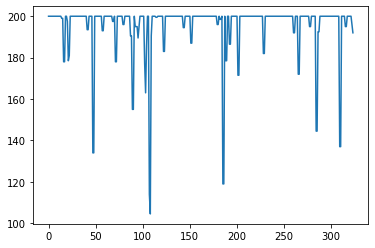

In [65]:
plt.plot(np.gradient(agent.rewL[testing_len:]))

In [ ]:
episodes = 500
rewL=[]
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    steps=0
    while not done and steps<=200:
        # env.render()
        action,_ = agent.model.predict(state)
        state, reward, done, info = env.step(action)
        score+=reward
        steps+=1
    # print('Episode:{} Score:{}'.format(episode, score))
    rewL+=[score]
env.close()

In [35]:
from matplotlib import pyplot as plt
import numpy as np

In [36]:
np.array(rewL).mean()

198.484

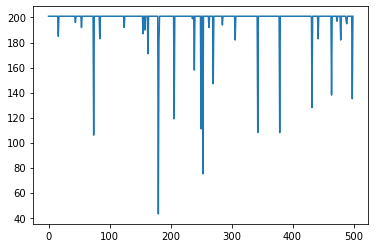

In [37]:
plt.plot(rewL)